In [404]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import random
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [405]:
df = pd.read_csv('monthly_FRED-MD_2024-12_processed.csv')

# Deep Learning

In [406]:
NUMBER_OF_LAGS = 7
TRAIN_RATIO = 0.7
HIDDEN_DIM = 128
NUM_LAYERS = 3
DROPOUT = 0.1
LR = 3e-4
BATCH_SIZE = 128
EPOCHS = 50

In [407]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


In [408]:
# Keep only numeric features (drop target)
numeric = df.select_dtypes(include=[np.number]).copy()
X_all = numeric.drop(columns=["sign", "volatility"]).values
y_vola = np.log(numeric["volatility"].values)

In [409]:
# Create sliding-window sequences
def create_sequences(X, y_vola, window):
    Xs, yv = [], []
    for i in range(window, len(X)):
        Xs.append(X[i - window : i, :])
        yv.append(y_vola[i])
    return np.array(Xs), np.array(yv)

X_seq, y_seq = create_sequences(X_all, y_vola, NUMBER_OF_LAGS)

In [410]:
X_seq.shape

(782, 7, 113)

In [411]:
train_size = int(len(X_seq) * TRAIN_RATIO)
X_train = X_seq[:train_size]; X_test = X_seq[train_size:]
yv_train = y_seq[:train_size]; yv_test = y_seq[train_size:]

In [412]:
# Torch datasets
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
yv_train_t = torch.tensor(yv_train, dtype=torch.float32).unsqueeze(1).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train_t, yv_train_t)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Define LSTM Model

In [413]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=16, num_layers=1, dropout=0.0):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

input_dim = X_train.shape[2]
model = SimpleLSTM(input_dim=input_dim, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, dropout=DROPOUT)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()

In [414]:
model

SimpleLSTM(
  (lstm): LSTM(113, 128, num_layers=3, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

## Model Training

X_train_t contains batch size, sequence length (number of lags) and number of variables.
Pytorch automatically calls forward()-method when input is given to the model.

In [415]:
train_losses = []
model.train()
for epoch in range(EPOCHS+1):     # number of seeing the training data for learning parameters
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    train_losses.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss = {loss.item():.4f}")

Epoch 0: loss = 11.8027
Epoch 10: loss = 0.0963
Epoch 20: loss = 0.0466
Epoch 30: loss = 0.0404
Epoch 40: loss = 0.0332
Epoch 50: loss = 0.0299


### Out of sample Prediction

In [416]:
model.eval()
with torch.no_grad():
    vol_preds = model(X_test_t).squeeze().numpy()

In [417]:
# regression metrics for volatility
mse_vol = mean_squared_error(yv_test, vol_preds)
rmse_vol = root_mean_squared_error(yv_test, vol_preds)
mae = mean_absolute_error(yv_test, vol_preds)
print(f"Volatility MSE (original units): {mse_vol:.6f}")
print(f"Volatility RMSE (original units): {rmse_vol:.6f}")
print(f"Volatility MAE (original units): {mae:.6f}")

Volatility MSE (original units): 0.056709
Volatility RMSE (original units): 0.238136
Volatility MAE (original units): 0.179915


In [418]:
def count_parameters(m):
    total = sum(p.numel() for p in m.parameters())
    trainable = sum(p.numel() for p in m.parameters() if p.requires_grad)
    print(f"Total params: {total:,} | Trainable params: {trainable:,}")

count_parameters(model)

print(f"Data points: {df.shape[0]*df.shape[1]}")

Total params: 388,737 | Trainable params: 388,737
Data points: 90735


# Model Diagnostics

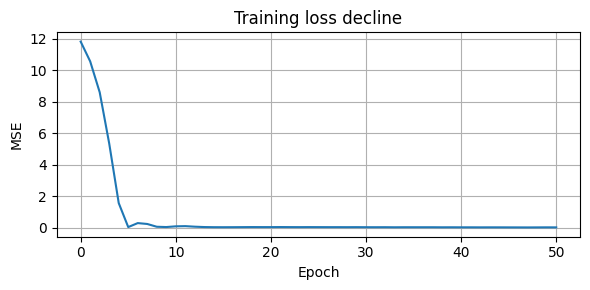

In [419]:
plt.figure(figsize=(6,3))
plt.plot(train_losses, label='train MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training loss decline')
plt.grid(True)
plt.tight_layout()
plt.show()

In [420]:
# train_losses = []
# val_losses = []

# # prepare test target tensor once
# yv_test_t = torch.tensor(yv_test, dtype=torch.float32).unsqueeze(1).to(device)

# model.train()
# for epoch in range(EPOCHS + 1):
#     total_loss = 0.0
#     total_n = 0
#     for X_batch, y_batch in train_loader:
#         X_batch = X_batch.to(device)
#         y_batch = y_batch.to(device)

#         optimizer.zero_grad()
#         y_pred = model(X_batch)
#         loss = criterion(y_pred, y_batch)
#         loss.backward()
#         optimizer.step()

#         b = X_batch.size(0)
#         total_loss += loss.item() * b   # batch-mean -> batch-sum
#         total_n += b

#     epoch_train_loss = total_loss / max(1, total_n)
#     train_losses.append(epoch_train_loss)

#     # validation loss on full test set
#     model.eval()
#     with torch.no_grad():
#         val_pred = model(X_test_t.to(device))
#         val_loss = criterion(val_pred, yv_test_t).item()
#     val_losses.append(val_loss)
#     model.train()

#     if epoch % 10 == 0 or epoch == 0 or epoch == EPOCHS:
#         print(f"Epoch {epoch}: train_mse = {epoch_train_loss:.6f} | val_mse = {val_loss:.6f}")

# # simple plot
# import matplotlib.pyplot as plt
# plt.figure(figsize=(6,3))
# plt.plot(train_losses, label='train MSE')
# plt.plot(val_losses, label='val MSE')
# plt.xlabel('Epoch')
# plt.ylabel('MSE')
# plt.ylim(0.01, 0.2)
# plt.legend()
# plt.title('Train vs Validation Loss')
# plt.grid(True)
# plt.tight_layout()
# plt.show()